<a href="https://colab.research.google.com/github/mingshey/python_wave/blob/main/Wave2d_Balloon1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 유한차분법(FDM; finite difference method)에 의한 파동 시뮬레이션

공기 중의 음파와 같은 단순한 스칼라 장의 이차원 파동 방정식은 다음과 같은 편미분 방정식 형태로 주어진다.
$$ \frac{\partial^2 f}{\partial t ^2} = c^2\left(\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}\right)$$

여기서 $c$는 파동의 전파 속력이다. 이것을 유한한 간격의 차분 방정식으로 변환하면 다음과 같다.
$$ \frac{\left\{ f(x, y)_{n+1} - f(x, y)_{n} \right) - \left( f(x, y)_{n} - f(x, y)_{n-1} \right\}}{\Delta t ^{2}} = c^{2}\left[ \frac{\left\{ f(x+h, y)_n - f(x,y)_{n} \right\} - \left\{ f(x, y)_{n} - f(x-h, y)_{n-1} \right\}}{h ^2} + \frac{\left\{ f(x, y+h)_n - f(x, y)_{n} \right\} - \left\{ f(x, y)_{n} - f(x, y-h)_{n-1} \right\}}{h ^2} \right]$$
여기서 $h(=\Delta x =\Delta y)$ 는 $x,\space y$ 평면상의 격자 점 간격이고, $\Delta t$는 시간 간격이다. 아래 첨자 $n$은 현재의 값, $n-1$은  $\Delta t$ 이전 과거의 값, $n+1$은  $\Delta t$ 이후 미래의 값을 의미한다.
$(x, y)$에서 $\Delta t$이후 미래의 $f$값 $f(x, y)_{n+1}$에 대하여 정리하면,

$$f(x, y)_{n+1} = 2f(x,y)_n -f(x,y)_{n-1} + \frac{c^2}{(h/\Delta t)^{2}}\left\{
  f(x-h, y)_n + f(x+h, y)_n + f(x, y-h)_n + f(x, y+h)_n - 4 f(x, y)_n \right\}$$

즉, 미래의 값 $f(x, y)_{n+1}$은, 현재의 값 $f(x, y)_n$에 현재 값과 과거 값의 차 $f(x, y)_n - f(x, y)_{n-1}$을 더하고, 다시 현재 시점에서 주변 값과의 차이에 파동의 속력을 반영한 값을 더해서 구한다.

In [ ]:
import numpy as np               # 배열(array)을 이용한 빠른 수치 연산
import matplotlib.pyplot as plt  # 그래프 작성

In [ ]:
import matplotlib.animation as anim           # 동영상 출력
from matplotlib.animation import PillowWriter # GIF 동영상 출력

* FDM 에 따라 현재 상태 및 한 단계 이전 상태로부터 한 단계 이후 상태를 구한다.
* 강제 진동하는 부분(파원)이 있는 경우 기존 상태와 무관하게 시간 $t$의 함수 $F(t)$ 형태로 미래 상태를 지정하는 식을 함수 마지막 부분에 넣어준다.

In [ ]:
def fdm_step(past, curr, med, rows, cols, tval):
  """
  유한차분법(Finite Differnce Method)에 의해 2차원 파동방정식을 적용하여
  2차원 파동의 진행을 1 time step 씩 진행한다.
  필요한 경우 강제 진동 식을 마지막에 추가한다.
  """
  fut = curr.copy() # 미래의 값
  fut[1:rows-1,1:cols-1] = (
      2.0*curr[1:rows-1,1:cols-1] - past[1:rows-1,1:cols-1]
      + med[1:rows-1,1:cols-1]*(curr[:rows-2,1:cols-1]
      +curr[2:rows,1:cols-1]+curr[1:rows-1,:cols-2]
      +curr[1:rows-1,2:cols]-4.0*curr[1:rows-1,1:cols-1]))

  """
  forced oscillation: 파원을 강제 진동시키는 식. (시간 tval의 식)
  """
  fut[rows//2 - 2 : rows//2 + 2, 0 : 2] = 10.0 * np.sin(2 * np.pi * freq * tval)

  tval = tval + dt

  return ([curr, fut, tval])

In [ ]:
"""
가로 세로 격자 수 설정:
"""
rs = 128
cs = 128

c = 331         # 공기중 파동의 속력: [m/s]
wl = 0.08       # 파장 [m]
freq = c / wl   # 강제진동 주파수 [Hz]
dt = 1.0e-6     # 시뮬레이션 시간 간격 [s])
dx = 0.01       # 격자 간격 [m])
cprime = dx/dt

In [ ]:
# 진동수
print(f'freq = {freq} Hz')

freq = 4137.5 Hz


In [ ]:
ci = rs//2 # Center i of Balloon
cj = cs*2//5 # Center j of Balloon
ri = rs//5 # Vertical half-diameter
rj = cs//6 # Horizontal half-diameter

def inside_balloon(i, j):
  return ((i-ci)/(ri))**2 + ((j-cj)/(rj))**2 <= 1.0

idx = np.indices((rs, cs))
inside = inside_balloon(idx[0], idx[1])

def draw_balloon(axis, color='w'):
  ts = np.linspace(0, 2*np.pi, 101)
  xs = cj + rj * np.cos(ts)
  ys = ci + ri * np.sin(ts)
  axis.plot(xs, ys, c=color)

# 매질의 성질:
mc = np.ones((rs, cs)) * c    # background medium

#풍선 내 매질의 성질
crelCO2 = (259.0/331.0)   # relative value of r for CO2 wrt. Air, 0 deg. C.
crelHe = (965.0/331.0)    # relative sound speed in He wrt. Air, 0 deg. C.
gas_CO2 = {'name':r"CO$_2$", 'relspd':crelCO2}
gas_He = {'name':"He", 'relspd':crelHe}
gases=[gas_CO2, gas_He]

# Select gas 0 = CO2, 1 = He
gas = gases[0]

# 풍선 내부 매질의 성질:
mc += c * (gas['relspd'] - 1.0) * inside

#
msq = (mc / cprime) ** 2

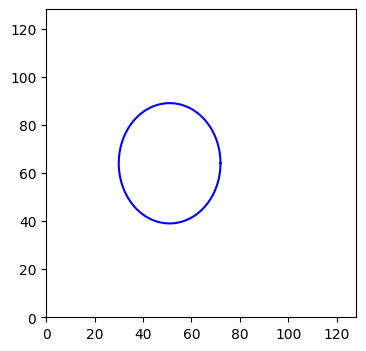

In [ ]:
# 풍선의 위치와 모양을 그려서 확인한다
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(0,cs)
ax.set_ylim(0,rs)
draw_balloon(ax, color='b')
#ax.contour(mc, [c*np.sqrt(gas["relspd"])], colors = 'navy', algorithm='threaded')

In [ ]:
#파동이 없는 평형 상태로 배경 설정
pm = np.zeros((rs, cs))  # past values 과거의 값
cm = np.zeros((rs, cs))  # current values 현재의 값

#점 펄스 파원:
#pm[rs//2-2:rs//2+2, 1:3] = 100.0
#cm[rs//2-2:rs//2+2, 1:3] = 100.0

# 시간 초기화
t = 0.0

In [ ]:
# 시뮬레이션을 진행하며 nn개 시간 간격마다 장면 이미지를 저장한다.
N = 4000 # 총 시뮬레이션 스텝 수
nn = 50  # 이미지 저장 간격
n = N//nn

ts = np.array([])
maps = np.array([])

for k in range(n):
  for i in range(nn):
    pm, cm, t = fdm_step(pm, cm, msq, rs, cs, t)
  maps = np.append(maps, cm)
  ts = np.append(ts, t)

maps = maps.reshape(-1,rs,cs)

r1 = rs//2 # 그래프로 나타낼 표본 행
r2 = rs//16

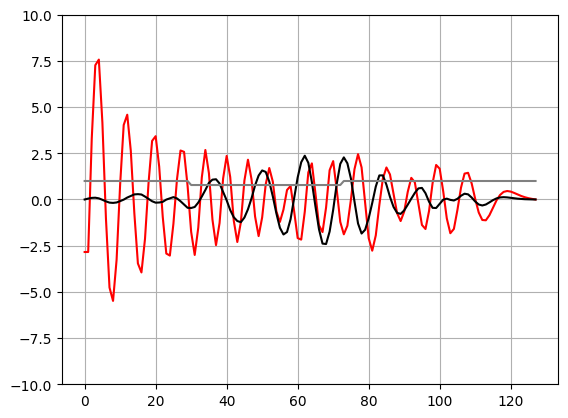

In [ ]:
plt.grid()
plt.ylim(-10,10)
plt.plot(maps[-1,r1, :], color='red')
plt.plot(maps[-1,rs//16, :], color='black')
plt.plot(mc[r1]/(c), color='gray')

In [ ]:
def frame(k):
  ax[1].cla()
  ax[0].cla()
  plt.subplot(121)
  ax[0].set_xlabel("x (cm)")
  ax[0].set_ylabel("y (cm)")
  ax[0].set_title(f"time = {ts[k]:.3e} (s)")
  ax[0].axhline(r1, color='red', alpha=0.3)
  ax[0].axhline(r2, color='k', alpha=0.3)
  ax[0].imshow(maps[k, :, :], vmin=-5,vmax=5)

  draw_balloon(ax[0])

  plt.subplot(122)
  ax[1].set_ylim([-10,10])
  ax[1].grid()
  ax[1].set_xlabel("x (cm)")
  ax[1].set_ylabel("wave displacement [arbitrary unit]")
  ax[1].set_title(gas['name'])
  ax[1].plot(maps[k, r1, :], c='r', label='Sample 1(red)')
  ax[1].plot(maps[k, r2, :], c='k', label='Sample 2(black)')
  ax[1].legend(loc='lower left')

  if k==0:
    ax2 = ax[1].twinx()
    ax2.set_ylabel('wave speed [m/s]')
    ax2.set_ylim([0,1000])
    ax2.plot(mc[r1, :], color='gray', label='wave speed(Sample1)')
    ax2.legend(loc='lower right')

  plt.suptitle(gas['name'] + " Balloon")

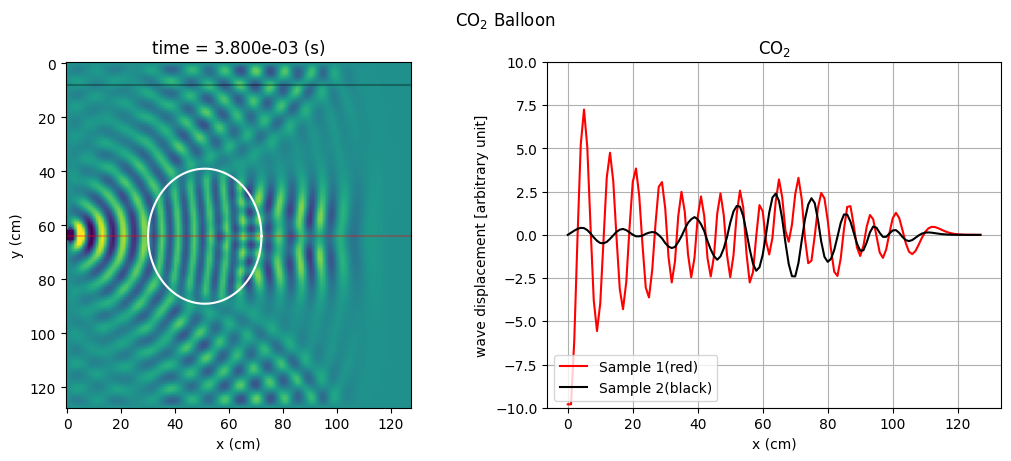

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4.5), constrained_layout=True)
frame(75)

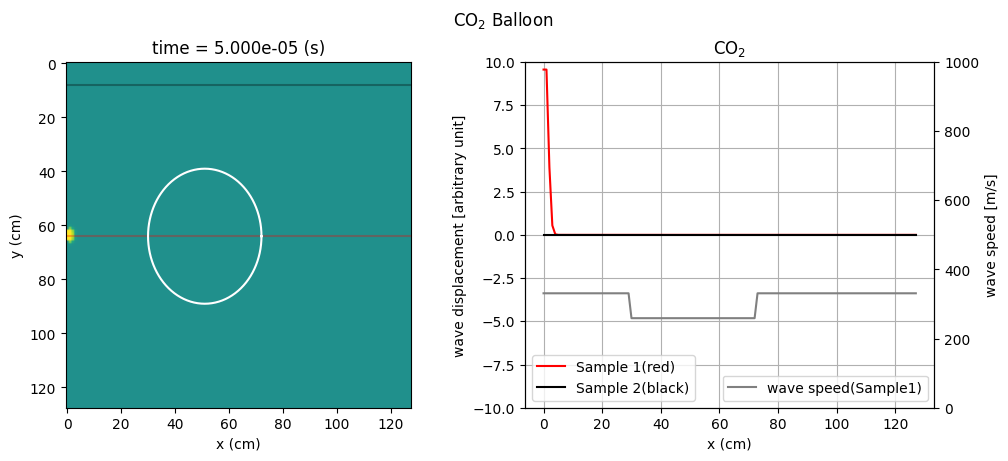

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4.5), constrained_layout=True)
ani = anim.FuncAnimation(fig, frame, frames=n)

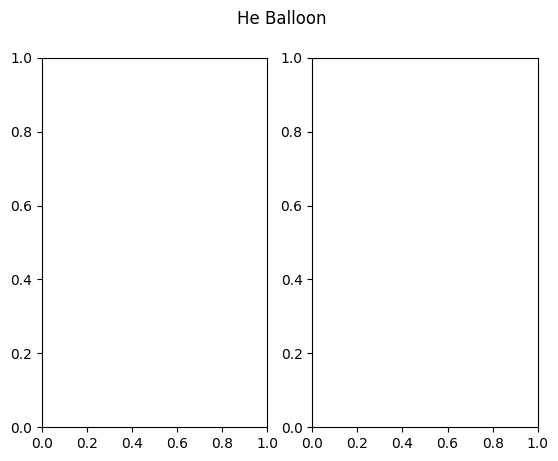

In [ ]:
ani.save('./wave2d-' + gas['name'] + '.gif',
         writer='pillow', fps=10)

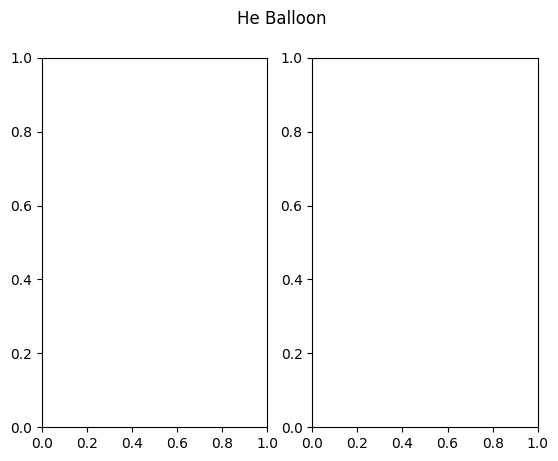

In [ ]:
ani.save('./wave2d-' + gas['name'] + '.avi', fps=10)